# 1st Assignment: NN's from Scratch

### Flàvia Ferrús Marimón

The objective is to build from scratch a neural network to perform  classification. Let's first consider the follwing 2-class dataset:

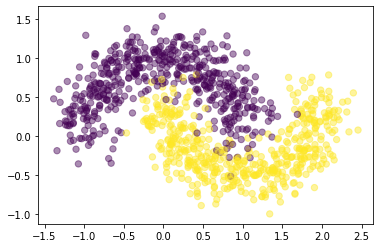

In [1]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a training dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

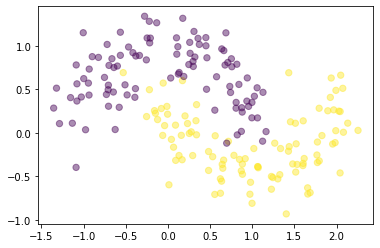

In [2]:
# Generate a testing dataset and plot it
np.random.seed(0)
Xt, yt = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(Xt[:,0], Xt[:,1], s=40, c=yt, alpha=0.45)

In [3]:
print(X[1], X.shape)
print(y[1], y.shape)

[1.80460944 0.00695963] (1000, 2)
1 (1000,)


## Classification

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer. 

+ The number of nodes in the input layer will be determined by the dimensionality of our data (2). 
+ Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2). 

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function $\sigma$. 


If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ \hat{y} = \mbox{softmax}({z_2})$$

where $\hat{y}$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network. 

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 

## Softmax

The last layer is a `softmax` function. The softmax function is a generalization of the logistic function to multiple dimensions. It is used to normalize the output of a network to a probability distribution over predicted output classes.

The softmax function takes as input a vector $C$ of real numbers, and normalizes it into a probability distribution consisting of $C$ probabilities proportional to the exponentials of the input numbers:

$$softmax(z_i) = \frac{exp(z_i)}{\sum_{j=1}^{C}exp(z_j))}$$

## Cross-entropy loss

A common choice with the softmax output is the **cross-entropy loss**. 

If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [4]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent

# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model


In [5]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.578993
Loss after iteration 1000: 0.318070
Loss after iteration 2000: 0.297688
Loss after iteration 3000: 0.292829
Loss after iteration 4000: 0.289559
Loss after iteration 5000: 0.286088
Loss after iteration 6000: 0.281947
Loss after iteration 7000: 0.276860
Loss after iteration 8000: 0.270635
Loss after iteration 9000: 0.263206
Loss after iteration 10000: 0.254674
Loss after iteration 11000: 0.245306
Loss after iteration 12000: 0.235476
Loss after iteration 13000: 0.225571
Loss after iteration 14000: 0.215925
Loss after iteration 15000: 0.206780
Loss after iteration 16000: 0.198287
Loss after iteration 17000: 0.190518
Loss after iteration 18000: 0.183483
Loss after iteration 19000: 0.177156
Loss after iteration 20000: 0.171486
Loss after iteration 21000: 0.166413
Loss after iteration 22000: 0.161872
Loss after iteration 23000: 0.157801
Loss after iteration 24000: 0.154141
Loss after iteration 25000: 0.150836
Loss after iteration 26000: 0.147835
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

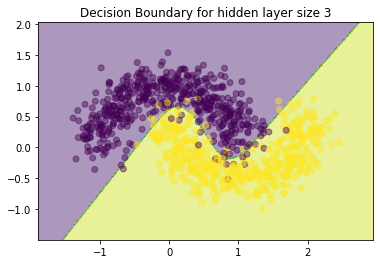

In [6]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

+ Report the classification accuracy using the testing dataset.

In [7]:
yt_hat = predict(model, Xt)
print(sklearn.metrics.accuracy_score(yt_hat,yt))

0.955


The classification accuracy using the testing dataset is 0.955.

# Exercise 2

+ Add an additional layer to your neural network model. 
+ Change the activation function and use a ReLU. 


## Neuronal model with 4 layers:


In [8]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent

# loss function for a 4-layer MLP
def loss_4(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = sigma(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# forward propagation
def predict_4(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = sigma(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

def build_model_4(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict_4(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss_4)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss_4(model)))
    
    return model


In [9]:
model2_1 = build_model_4(3)

In [10]:
yt_hat2_1 = predict_4(model2_1, Xt)
print(sklearn.metrics.accuracy_score(yt_hat2_1,yt))

0.97


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

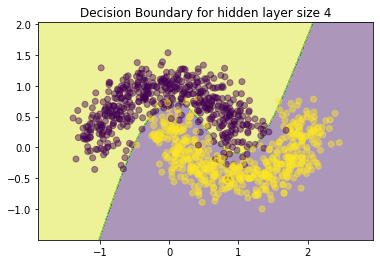

In [11]:
plot_decision_boundary(lambda x: predict(model2_1, x))
plt.title("Decision Boundary for hidden layer size 4")

## 4 layers and ReLU activation function

In [12]:
def relu(x):
    return(np.maximum(0, x))

sigma = relu # activation function

def loss_4(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = sigma(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# forward propagation
def predict_4(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = sigma(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

def build_model_4(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict_4(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss_4)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss_4(model)))
    
    return model


In [13]:
# Build a model with two 3-dimensional hidden layers
model2_2 = build_model_4(3)

In [14]:
yt_hat2_2 = predict_4(model2_2, Xt)
print(sklearn.metrics.accuracy_score(yt_hat2_2,yt))

0.875


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

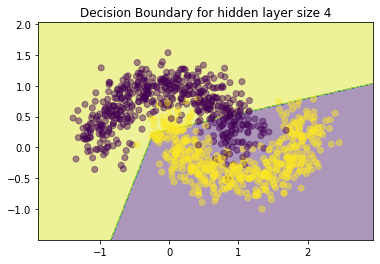

In [15]:
plot_decision_boundary(lambda x: predict(model2_2, x))
plt.title("Decision Boundary for hidden layer size 4")

In this case we get a quite worse result with the ReLU function. 

# Exercise 3

+ Design your own model (layers, activation function, number of units per layer, etc.) and train it to classify the following dataset. 
+ Train the model and report the classification accuracy using the testing dataset.


[0 0 0 ... 1 1 1]


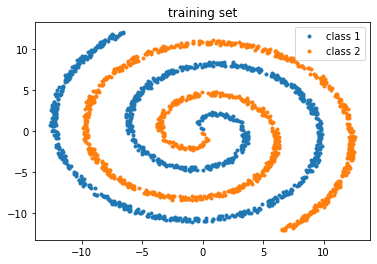

In [16]:
from autograd import grad
from autograd.misc import flatten

import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np


def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)

y = y.astype(int)

print(y)
plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

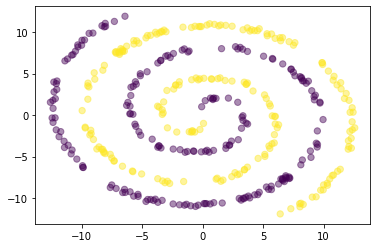

In [17]:
# Generate a testing dataset and plot it
np.random.seed(0)
Xt, yt = twospirals(200)
yt = yt.astype(int)

plt.scatter(Xt[:,0], Xt[:,1], s=40, c=yt, alpha=0.45)

In [18]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    

# 5-layer with ReLU

In [19]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

def relu(x):
    return(np.maximum(0, x))
sigma2 = relu

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent

# loss function for a 4-layer MLP
def loss_5(model):
    W1, b1, W2, b2, W3, b3, W4, b4 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma2(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = sigma2(z2)
    z3 = np.dot(a2,W3) + b3
    a3 = sigma2(z3)
    z4 = np.dot(a3,W4) + b4
    
    exp_scores = np.exp(z4)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# forward propagation
def predict_5(model, x):
    W1, b1, W2, b2, W3, b3, W4, b4 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4']
    z1 = np.dot(x,W1) + b1
    a1 = sigma2(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = sigma2(z2)
    z3 = np.dot(a2,W3) + b3
    a3 = sigma2(z3)
    z4 = np.dot(a3,W4) + b4
    
    exp_scores = np.exp(z4)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

## nn_hdim is an array of length 3
def build_model_5_(nn_hdim, num_passes=50000, print_loss=False):
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim[0]) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim[0]))
    W2 = np.random.randn(nn_hdim[0], nn_hdim[1]) / np.sqrt(nn_hdim[0])
    b2 = np.zeros((1, nn_hdim[1]))
    W3 = np.random.randn(nn_hdim[1], nn_hdim[2]) / np.sqrt(nn_hdim[1])
    b3 = np.zeros((1, nn_hdim[2]))
    W4 = np.random.randn(nn_hdim[2], nn_output_dim) / np.sqrt(nn_hdim[2])
    b4 = np.zeros((1, nn_output_dim))


    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict_5(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss_5)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss_5(model)))
    
    return model


In [26]:
# Build a model with 3 hidden layers
model5_4D_3 = build_model_5_([11,12,13], print_loss=True)
model5_4D_3

Loss after iteration 0: 1.282510
Loss after iteration 1000: 0.651863
Loss after iteration 2000: 0.649502
Loss after iteration 3000: 0.648044
Loss after iteration 4000: 0.646727
Loss after iteration 5000: 0.645256
Loss after iteration 6000: 0.643734
Loss after iteration 7000: 0.642026
Loss after iteration 8000: 0.640212
Loss after iteration 9000: 0.637961
Loss after iteration 10000: 0.635743
Loss after iteration 11000: 0.633478
Loss after iteration 12000: 0.631356
Loss after iteration 13000: 0.629176
Loss after iteration 14000: 0.626108
Loss after iteration 15000: 0.623271
Loss after iteration 16000: 0.620927
Loss after iteration 17000: 0.618692
Loss after iteration 18000: 0.616259
Loss after iteration 19000: 0.609942
Loss after iteration 20000: 0.604779
Loss after iteration 21000: 0.594356
Loss after iteration 22000: 0.587039
Loss after iteration 23000: 0.579401
Loss after iteration 24000: 0.569155
Loss after iteration 25000: 0.556502
Loss after iteration 26000: 0.538553
Loss after ite

{'W1': array([[ 1.18324944,  0.56964879,  0.61532755,  1.47921394,  1.05305653,
         -1.16980244,  0.27916705, -0.01393043, -0.37307002, -0.14718019,
          0.23420776],
        [ 1.2173778 ,  0.71258573,  0.17025113,  0.07297312,  0.3670753 ,
          1.19064277, -0.39829971,  0.45034484, -0.35289726, -1.89288744,
          0.39836188]]),
 'b1': array([[ 0.71058357, -1.10027116, -1.01259932, -0.6979066 ,  1.15175491,
         -0.6239731 , -1.2746636 , -0.60911154, -1.05352579,  0.08049123,
         -0.68552629]]),
 'W2': array([[ 4.99219541e-01, -2.21379816e-01,  8.83309745e-01,
         -1.04162433e+00, -1.26301026e-01, -3.41104615e-01,
          3.34351858e-01,  7.21788634e-02,  5.34695683e-02,
         -3.50351163e-01, -2.63647283e-01, -6.63258413e-01],
        [-3.45960418e-01, -2.19081571e-03,  4.56217058e-01,
          1.41146187e-01, -2.28564560e-01,  1.63150655e-02,
         -1.03544822e-01, -4.19831107e-01, -5.14430582e-01,
          1.37652929e+00, -2.20625888e-01, -

1.0


Text(0.5, 1.0, 'Decision Boundary for 5 layers model')

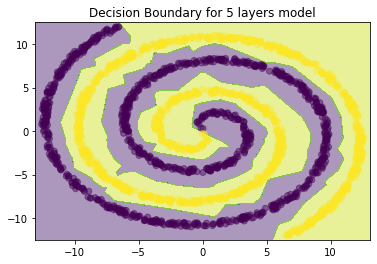

In [27]:
yt_hat5_4D_3 = predict_5(model5_4D_3, Xt)
print(sklearn.metrics.accuracy_score(yt_hat5_4D_3,yt))
# Plot the decision boundary
plot_decision_boundary(lambda x: predict_5(model5_4D_3, x))
plt.title("Decision Boundary for 5 layers model")

Note that with just 3 hidden layers with 11,12 and 13 nodes we can attain an accuracy of 1. However, we could consider a model with 6 layers to contrast results. 

# 6-layer with ReLU

In [28]:
## 6-layer model
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

def relu(x):
    return(np.maximum(0, x))
sigma2 = relu

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent

# loss function for a 4-layer MLP
def loss_6(model):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'],  model['W5'], model['b5']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma2(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = sigma2(z2)
    z3 = np.dot(a2,W3) + b3
    a3 = sigma2(z3)
    z4 = np.dot(a3,W4) + b4
    a4 = sigma2(z4)
    z5 = np.dot(a4,W5) + b5
    
    exp_scores = np.exp(z5)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# forward propagation
def predict_6(model, x):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'],  model['W5'], model['b5']
    z1 = np.dot(x,W1) + b1
    a1 = sigma2(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = sigma2(z2)
    z3 = np.dot(a2,W3) + b3
    a3 = sigma2(z3)
    z4 = np.dot(a3,W4) + b4
    a4 = sigma2(z4)
    z5 = np.dot(a4,W5) + b5
    
    exp_scores = np.exp(z5)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

## nn_hdim is now an array of 4
def build_model_6(nn_hdim, num_passes=50000, print_loss=False):
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim[0]) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim[0]))
    W2 = np.random.randn(nn_hdim[0], nn_hdim[1]) / np.sqrt(nn_hdim[0])
    b2 = np.zeros((1, nn_hdim[1]))
    W3 = np.random.randn(nn_hdim[1], nn_hdim[2]) / np.sqrt(nn_hdim[1])
    b3 = np.zeros((1, nn_hdim[2]))
    W4 = np.random.randn(nn_hdim[2], nn_hdim[3]) / np.sqrt(nn_hdim[2])
    b4 = np.zeros((1, nn_hdim[3]))
    W5 = np.random.randn(nn_hdim[3], nn_output_dim) / np.sqrt(nn_hdim[3])
    b5 = np.zeros((1, nn_output_dim))


    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4, 'W5': W5, 'b5': b5}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict_6(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss_6)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss_6(model)))
    
    return model


In [35]:
# Build a model with 3 4-dimensional hidden layers
model6_p7 = build_model_6([9,10,11,12], num_passes=50000, print_loss=True)
model6_p7

Loss after iteration 0: 0.951213
Loss after iteration 1000: 0.663241
Loss after iteration 2000: 0.656466
Loss after iteration 3000: 0.651774
Loss after iteration 4000: 0.648639
Loss after iteration 5000: 0.645794
Loss after iteration 6000: 0.642890
Loss after iteration 7000: 0.639985
Loss after iteration 8000: 0.637091
Loss after iteration 9000: 0.634161
Loss after iteration 10000: 0.631455
Loss after iteration 11000: 0.629004
Loss after iteration 12000: 0.626677
Loss after iteration 13000: 0.624035
Loss after iteration 14000: 0.621084
Loss after iteration 15000: 0.617884
Loss after iteration 16000: 0.609996
Loss after iteration 17000: 0.588725
Loss after iteration 18000: 0.557712
Loss after iteration 19000: 0.518729
Loss after iteration 20000: 0.490345
Loss after iteration 21000: 0.445129
Loss after iteration 22000: 0.419644
Loss after iteration 23000: 0.406425
Loss after iteration 24000: 0.304869
Loss after iteration 25000: 0.262438
Loss after iteration 26000: 0.238090
Loss after ite

{'W1': array([[ 1.18125214,  0.07461205,  1.07326351,  1.37765316,  1.08548922,
         -0.73223492,  0.43894436, -0.58555609,  0.41479864],
        [ 0.21046155,  0.54440711,  0.74044581,  0.63942804,  0.23537752,
         -0.61062598,  0.55170437,  1.27648007, -0.39315919]]),
 'b1': array([[-1.0216733 , -0.81867873,  1.1998925 , -0.34244503, -0.40106016,
         -0.78234059, -0.66070757, -0.61835673, -0.56460052]]),
 'W2': array([[ 0.09940263, -0.10314001, -0.67892635,  0.81009955,  0.28339985,
         -0.31647499,  0.94702839, -0.83888301,  0.01525284, -0.2851262 ],
        [ 0.5109264 ,  0.75598367,  0.05772214,  0.62672348, -0.29195697,
         -0.78771215, -0.13809017,  0.11289683,  0.40712497,  0.36175977],
        [ 0.04221465, -0.26586568, -0.36478182, -1.01719673, -0.59459024,
          1.07982354, -0.40916631,  0.18500187, -0.44151903,  0.29708734],
        [-0.53817444,  0.11087799, -0.41639753,  0.35516169, -0.17026838,
         -0.27716247, -0.14863601,  0.27183675,  

1.0


Text(0.5, 1.0, 'Decision Boundary for 6 layers model with increasing nodes')

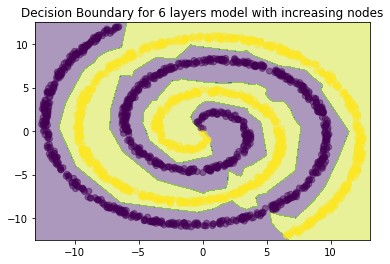

In [36]:
yt_hat6_p7 = predict_6(model6_p7, Xt)
print(sklearn.metrics.accuracy_score(yt_hat6_p7,yt))
# Plot the decision boundary
plot_decision_boundary(lambda x: predict_6(model6_p7, x))
plt.title("Decision Boundary for 6 layers model with increasing nodes")

Note that by using the same structure but increasing the number of layers by one we can also attain an accuracy of 1, using 1 node less on the higher layer. However, computationally this model requires more neurons. Nevertheless, looking at the boundary plot, we can see that the model with 6 layers adjusts more precisely the test set, regardeless that the accuracy remains the same in both cases. Let's consider lastly a 7 layer model, to finish this study.

# 7 layer model

In [37]:
## 6-layer model
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

def relu(x):
    return(np.maximum(0, x))
sigma2 = relu

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent

# loss function for a 4-layer MLP
def loss_7(model):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'],  model['W5'], model['b5'], model['W6'], model['b6']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma2(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = sigma2(z2)
    z3 = np.dot(a2,W3) + b3
    a3 = sigma2(z3)
    z4 = np.dot(a3,W4) + b4
    a4 = sigma2(z4)
    z5 = np.dot(a4,W5) + b5
    a5 = sigma2(z5)
    z6 = np.dot(a5,W6) + b6
    
    exp_scores = np.exp(z6)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# forward propagation
def predict_7(model, x):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'],  model['W5'], model['b5'], model['W6'], model['b6']
    z1 = np.dot(x,W1) + b1
    a1 = sigma2(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = sigma2(z2)
    z3 = np.dot(a2,W3) + b3
    a3 = sigma2(z3)
    z4 = np.dot(a3,W4) + b4
    a4 = sigma2(z4)
    z5 = np.dot(a4,W5) + b5
    a5 = sigma2(z5)
    z6 = np.dot(a5,W6) + b6
    
    exp_scores = np.exp(z6)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

## nn_hdim is now an array of 5
def build_model_7(nn_hdim, num_passes=50000, print_loss=False):
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim[0]) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim[0]))
    W2 = np.random.randn(nn_hdim[0], nn_hdim[1]) / np.sqrt(nn_hdim[0])
    b2 = np.zeros((1, nn_hdim[1]))
    W3 = np.random.randn(nn_hdim[1], nn_hdim[2]) / np.sqrt(nn_hdim[1])
    b3 = np.zeros((1, nn_hdim[2]))
    W4 = np.random.randn(nn_hdim[2], nn_hdim[3]) / np.sqrt(nn_hdim[2])
    b4 = np.zeros((1, nn_hdim[3]))
    W5 = np.random.randn(nn_hdim[3], nn_hdim[4]) / np.sqrt(nn_hdim[3])
    b5 = np.zeros((1, nn_hdim[4]))
    W6 = np.random.randn(nn_hdim[4], nn_output_dim) / np.sqrt(nn_hdim[4])
    b6 = np.zeros((1, nn_output_dim))


    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4, 'W5': W5, 'b5': b5, 'W6': W6, 'b6': b6}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict_7(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss_7)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss_7(model)))
    
    return model


In [38]:
model7_p6 = build_model_7([6,7,8,9,10], num_passes=50000, print_loss=True)
model7_p6

Loss after iteration 0: 0.695662
Loss after iteration 1000: 0.666459
Loss after iteration 2000: 0.660499
Loss after iteration 3000: 0.654579
Loss after iteration 4000: 0.649668
Loss after iteration 5000: 0.645921
Loss after iteration 6000: 0.642281
Loss after iteration 7000: 0.639524
Loss after iteration 8000: 0.637554
Loss after iteration 9000: 0.635428
Loss after iteration 10000: 0.633339
Loss after iteration 11000: 0.632037
Loss after iteration 12000: 0.630986
Loss after iteration 13000: 0.630084
Loss after iteration 14000: 0.629453
Loss after iteration 15000: 0.629111
Loss after iteration 16000: 0.628746
Loss after iteration 17000: 0.627974
Loss after iteration 18000: 0.627671
Loss after iteration 19000: 0.626744
Loss after iteration 20000: 0.626172
Loss after iteration 21000: 0.625353
Loss after iteration 22000: 0.625247
Loss after iteration 23000: 0.623892
Loss after iteration 24000: 0.622221
Loss after iteration 25000: 0.616891
Loss after iteration 26000: 0.613658
Loss after ite

{'W1': array([[ 1.08879653,  0.4481474 ,  0.03293029,  1.31563172,  1.18043313,
         -1.10206697],
        [ 0.99522547,  0.06369653, -1.30378656,  0.71201681,  0.20226256,
          0.34908586]]),
 'b1': array([[-0.34454535,  0.08098961, -0.07717187,  0.03941814,  0.13961826,
         -0.22290795]]),
 'W2': array([[ 0.23701209,  0.04967362,  0.09934374, -0.06309663,  0.88452321,
          0.03374312,  0.12780935],
        [-0.35802707, -1.04225373,  0.32026493,  0.36135113, -0.44637308,
          0.90785806, -0.5937423 ],
        [ 0.01325756, -0.07641749,  1.08998991,  0.8940056 ,  0.10002951,
          0.09840777, -0.36243701],
        [-0.88780418, -0.14203454, -0.00137138,  0.20815403,  0.13973518,
         -0.10138236, -0.12341458],
        [-0.45833022, -0.5797199 , -0.44969181,  0.50806781, -0.57242524,
         -0.31331145, -0.51145156],
        [ 0.61806099, -0.65887104, -0.11358451,  0.01557864,  0.37809693,
         -0.08960709, -0.48199107]]),
 'b2': array([[-4.8956565

1.0


Text(0.5, 1.0, 'Decision Boundary for 6 layers model with increasing nodes')

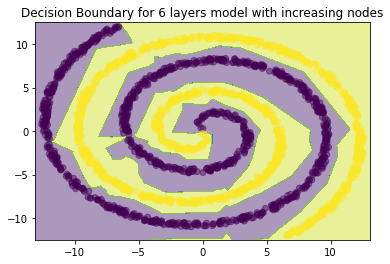

In [39]:
yt_hat7_p6 = predict_7(model7_p6, Xt)
print(sklearn.metrics.accuracy_score(yt_hat7_p6,yt))
# Plot the decision boundary
plot_decision_boundary(lambda x: predict_7(model7_p6, x))
plt.title("Decision Boundary for 6 layers model with increasing nodes")

Note that again the accuracy reached is equal to 1, evidencing the effcientcy of this approach in this kind of problem. It is interesting to observe that the number of nodes needed per layer decreases as we increase the number of layers used in the model. This matches the theoretically expected, since adding new layers we are adding linear classifiers that increases the direction boundaries used on the model. Therefore, increasing the number of layers and modifying the number of nodes, in a model caracterized by an ascending number of nodes per layer we can get a good accuracy result, which gets more precise (i.e. more adjusted to the specific dataset path) as we increase the number of layers. 

The model I would use, if need of choosing one of them would be the one with 7 layers, since it appears to be more precise, and adjusted to the system studied. However, iin need of computation time the more efficient is the one given by the model with 5 layers. 